In [ ]:
# Install required packages
!pip install pandas numpy sklearn seaborn matplotlib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [ ]:
# Create sample dataset
np.random.seed(42)

In [ ]:
# Generate dates for one year with daily readings
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
n_samples = len(dates)


In [ ]:
# Create sample data
data = {
    'date': dates,
    'temperature': np.random.normal(25, 5, n_samples),  # Temperature in Celsius
    'humidity': np.random.normal(60, 15, n_samples),    # Humidity percentage
    'soil_moisture': np.random.normal(35, 10, n_samples), # Soil moisture percentage
    'rainfall': np.random.exponential(5, n_samples),    # Rainfall in mm
    'soil_ph': np.random.normal(6.5, 0.5, n_samples),  # pH level
    'nitrogen': np.random.normal(45, 15, n_samples),    # Nitrogen content (mg/kg)
    'phosphorus': np.random.normal(35, 10, n_samples),  # Phosphorus content (mg/kg)
    'potassium': np.random.normal(40, 12, n_samples),   # Potassium content (mg/kg)
    'sunlight': np.random.normal(70, 20, n_samples),    # Sunlight exposure percentage
}

In [ ]:
# Create crop yield based on features (simplified relationship)
data['crop_yield'] = (
    0.3 * data['temperature'] +
    0.2 * data['humidity'] +
    0.15 * data['soil_moisture'] +
    0.1 * data['rainfall'] +
    -0.1 * abs(data['soil_ph'] - 6.5) * 10 +  # Optimal pH is 6.5
    0.1 * data['nitrogen'] +
    0.1 * data['phosphorus'] +
    0.1 * data['potassium'] +
    0.15 * data['sunlight']
) + np.random.normal(0, 10, n_samples)  # Add some noise

In [ ]:
# Create DataFrame
df = pd.DataFrame(data)


In [ ]:
# Display first few rows
print("Sample of the dataset:")
print(df.head())
print("\nDataset shape:", df.shape)

Sample of the dataset:
        date  temperature   humidity  soil_moisture   rainfall   soil_ph  \
0 2023-01-01    27.483571  53.981693      36.958453   1.900128  6.459642   
1 2023-01-02    24.308678  63.361387      25.216272   3.538613  6.638272   
2 2023-01-03    28.238443  60.188886      39.082528   0.212309  6.899750   
3 2023-01-04    32.615149  61.465141      17.974164   0.802858  6.179753   
4 2023-01-05    23.829233  48.404853      45.291556  21.573755  6.584198   

    nitrogen  phosphorus  potassium   sunlight  crop_yield  
0  20.904345   34.583192  41.628623  56.463416   53.644828  
1  56.688511   55.179080  41.978922  62.787042   52.019987  
2  60.751659   37.163169  31.667704  80.778384   48.206495  
3  32.040732   45.536124  43.959754  75.923696   26.927289  
4  51.424694   27.765372  27.906233  77.504339   45.941722  

Dataset shape: (365, 11)


In [ ]:
# Data Preprocessing
class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()

    def preprocess(self, data, is_training=False):
        # Create copy of data
        df_processed = data.copy()

        # Extract date features
        df_processed['month'] = df_processed['date'].dt.month
        df_processed['day_of_year'] = df_processed['date'].dt.dayofyear

        # Handle missing values
        df_processed = df_processed.fillna(df_processed.mean())

        # Remove outliers using IQR method
        Q1 = df_processed.quantile(0.25)
        Q3 = df_processed.quantile(0.75)
        IQR = Q3 - Q1

        # Only apply to numerical columns excluding date and target
        numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
        numerical_cols = numerical_cols.drop('crop_yield')

        for col in numerical_cols:
            lower_bound = Q1[col] - 1.5 * IQR[col]
            upper_bound = Q3[col] + 1.5 * IQR[col]
            df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)

        return df_processed

In [ ]:
# Exploratory Data Analysis
def perform_eda(data):
    # Basic statistics
    print("\nBasic Statistics:")
    print(data.describe())

    # Correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # Distribution plots for key features
    features_to_plot = ['temperature', 'humidity', 'soil_moisture', 'rainfall', 'crop_yield']
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features_to_plot, 1):
        plt.subplot(3, 2, i)
        sns.histplot(data[feature], kde=True)
        plt.title(f'{feature} Distribution')
    plt.tight_layout()
    plt.show()

    # Time series plot of crop yield
    plt.figure(figsize=(15, 5))
    plt.plot(data['date'], data['crop_yield'])
    plt.title('Crop Yield Over Time')
    plt.xlabel('Date')
    plt.ylabel('Crop Yield')
    plt.tight_layout()
    plt.show()

In [ ]:
# Main execution
# Preprocess data
preprocessor = DataPreprocessor()
df_processed = preprocessor.preprocess(df)


Basic Statistics:
                      date  temperature    humidity  soil_moisture  \
count                  365   365.000000  365.000000     365.000000   
mean   2023-07-02 00:00:00    25.039222   59.415067      36.280655   
min    2023-01-01 00:00:00    12.140879   19.546700      10.984063   
25%    2023-04-02 00:00:00    21.733354   48.613010      29.647648   
50%    2023-07-02 00:00:00    25.291044   59.185577      36.664522   
75%    2023-10-01 00:00:00    28.128337   69.491728      42.090038   
max    2023-12-31 00:00:00    37.720811  100.809805      60.753622   
std                    NaN     4.641987   15.249048       9.528935   

         rainfall     soil_ph    nitrogen  phosphorus   potassium    sunlight  \
count  365.000000  365.000000  365.000000  365.000000  365.000000  365.000000   
mean     4.734317    6.507753   44.661554   34.790258   40.001388   69.091095   
min      0.024761    5.229757    2.512206    7.370074    6.925894   16.713354   
25%      1.469645    6.188

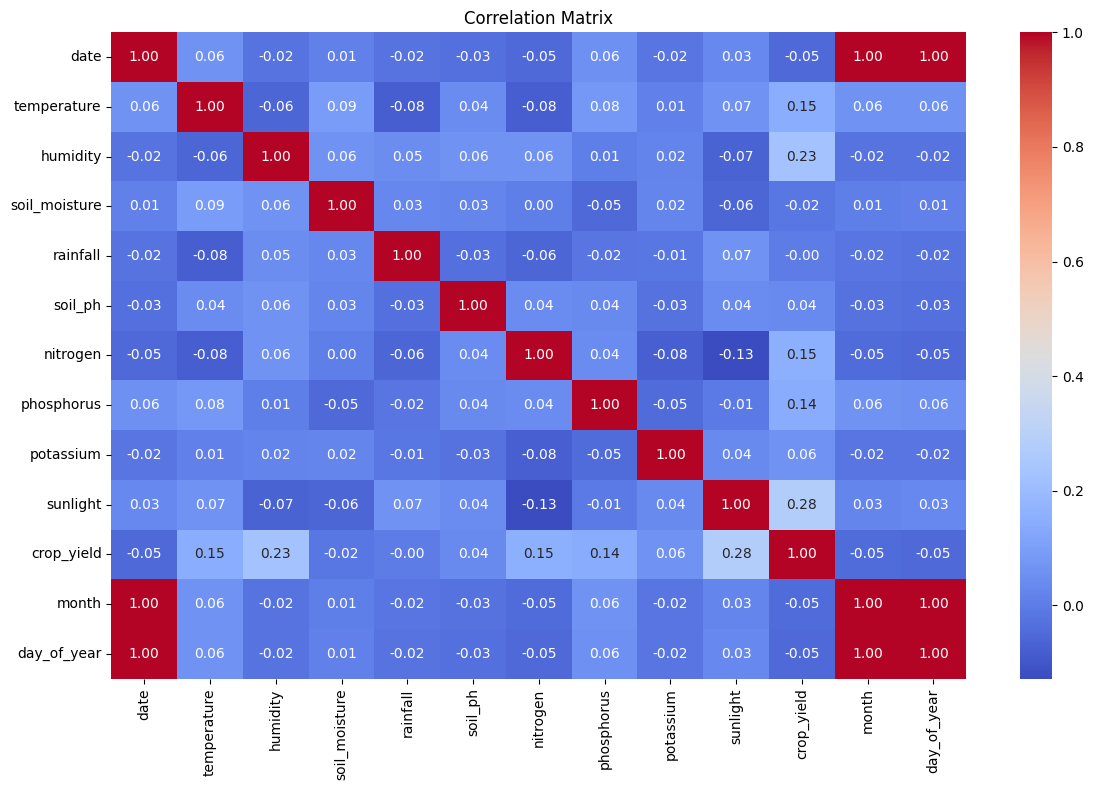

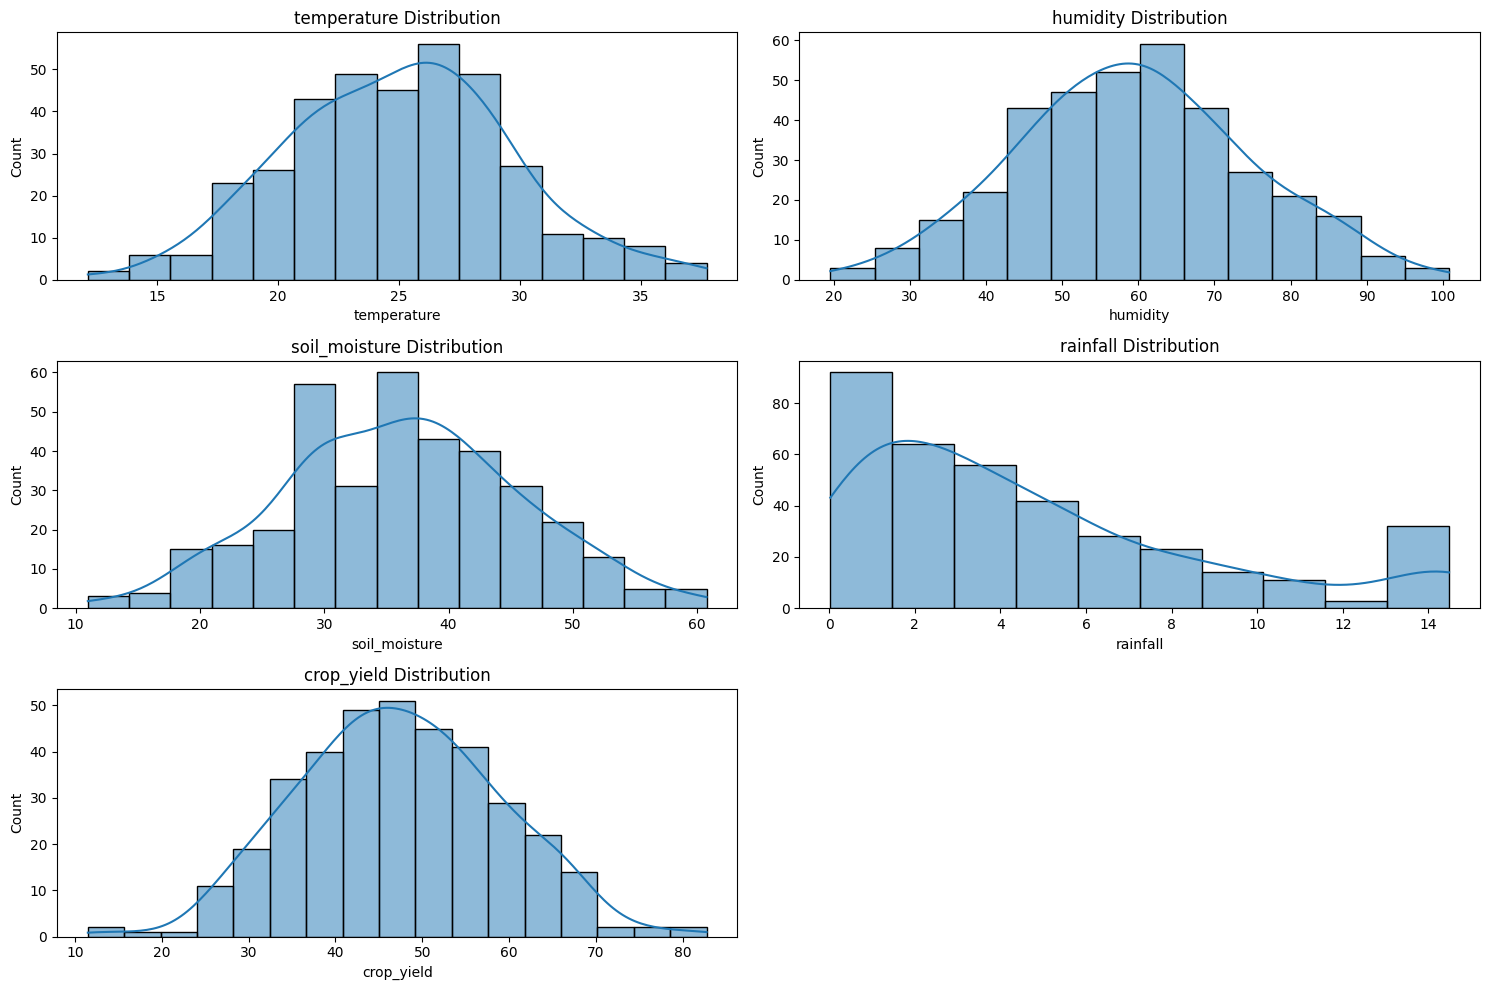

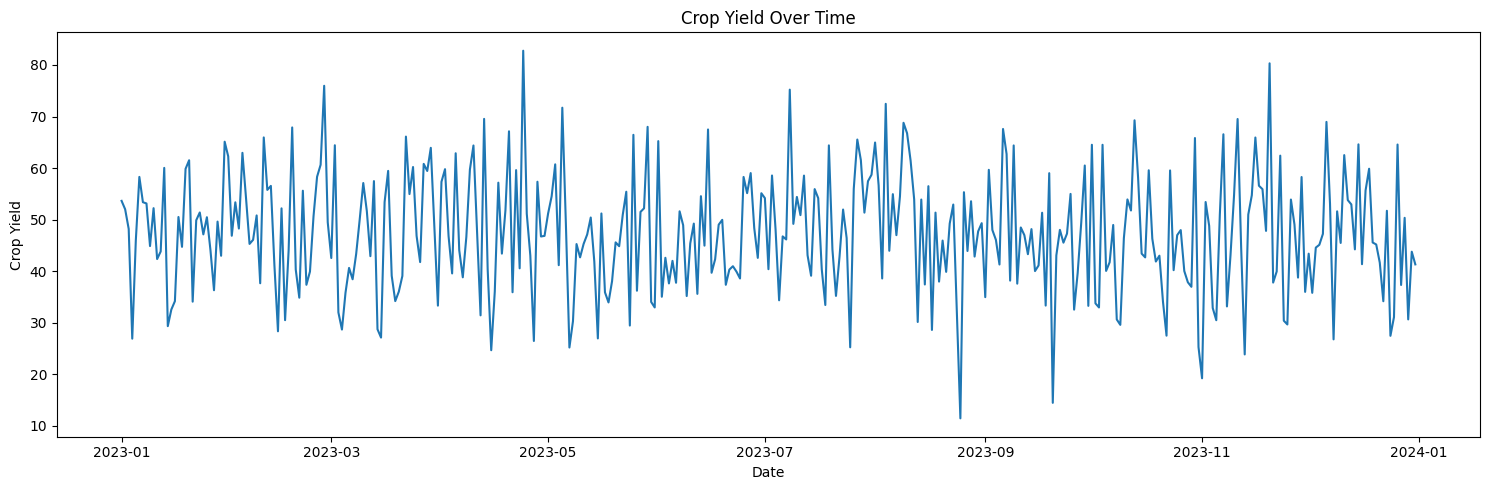

In [ ]:
# Perform EDA
perform_eda(df_processed)


Correlation:-


*   The strong positive correlations between humidity, sunlight, and crop yield suggest that these factors are likely to be important predictors of crop yield.
*   The weak correlation between 'month' and 'day_of_year' suggests that one of these features might be redundant and can potentially be removed to avoid multicollinearity.

Distribution plots:-


*   The distributions of temperature, humidity, soil moisture and crop yield are relatively symmetric and bell-shaped, which is expected for many natural phenomena.
*   The skewed distribution of rainfall suggests that there are more days with low rainfall compared to days with high rainfall.

Time series plot:-


*   The time series plot suggests that crop yield is influenced by factors that vary significantly over time.








In [ ]:
# Model Training and Evaluation
class FarmingModel:
    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.scaler = StandardScaler()

    def prepare_features(self, data):
        # Drop date and target columns for features
        feature_cols = data.drop(['date', 'crop_yield'], axis=1).columns
        X = data[feature_cols]
        y = data['crop_yield']

        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        return X_scaled, y, feature_cols

    def train_and_evaluate(self, X, y):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train model
        self.model.fit(X_train, y_train)

        # Make predictions
        y_pred = self.model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        return {
            'mse': mse,
            'rmse': np.sqrt(mse),
            'r2': r2,
            'test_actual': y_test,
            'test_pred': y_pred
        }

    def plot_feature_importance(self, feature_names):
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
        plt.tight_layout()
        plt.show()



In [ ]:
# Train and evaluate model
farming_model = FarmingModel()
X_scaled, y, feature_cols = farming_model.prepare_features(df_processed)
metrics = farming_model.train_and_evaluate(X_scaled, y)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {metrics['mse']:.2f}")
print(f"Root Mean Squared Error: {metrics['rmse']:.2f}")
print(f"R-squared Score: {metrics['r2']:.2f}")


Model Performance Metrics:
Mean Squared Error: 150.45
Root Mean Squared Error: 12.27
R-squared Score: 0.05


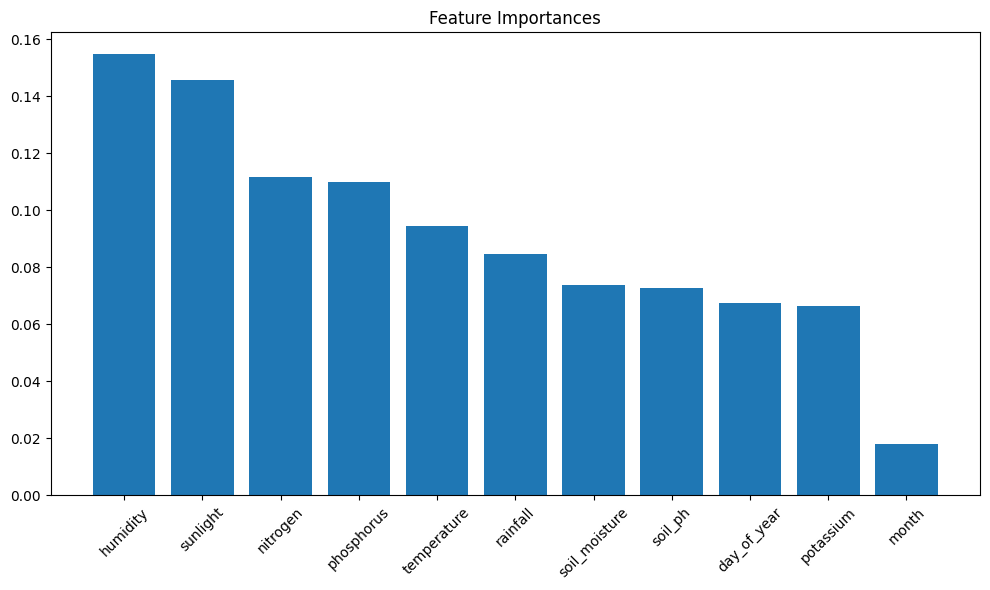

In [ ]:
# Plot feature importance
farming_model.plot_feature_importance(feature_cols)


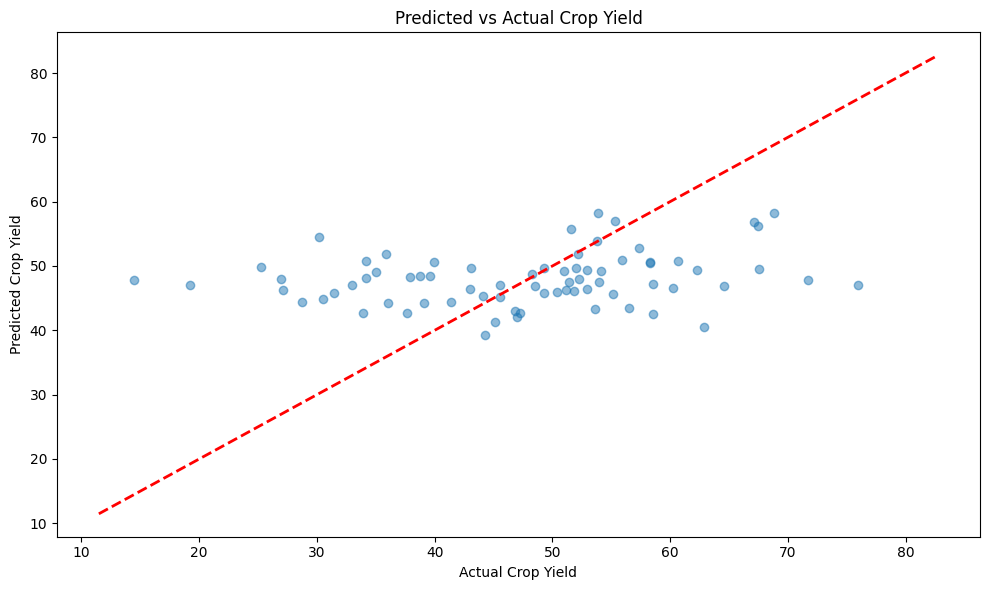

In [ ]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(metrics['test_actual'], metrics['test_pred'], alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Crop Yield')
plt.ylabel('Predicted Crop Yield')
plt.title('Predicted vs Actual Crop Yield')
plt.tight_layout()
plt.show()

Scattered points around the diagonal:
*   This suggests the model is making reasonable predictions, but there are some deviations between actual and predicted values.




In [61]:
# Example of making predictions for new data
def create_sample_prediction_data(n_samples=30):
    # Create sample data with the target column
    sample_data = pd.DataFrame({
        'date': pd.date_range(start='2024-01-01', periods=n_samples),
        'temperature': np.random.normal(25, 5, n_samples),
        'humidity': np.random.normal(60, 15, n_samples),
        'soil_moisture': np.random.normal(35, 10, n_samples),
        'rainfall': np.random.exponential(5, n_samples),
        'soil_ph': np.random.normal(6.5, 0.5, n_samples),
        'nitrogen': np.random.normal(45, 15, n_samples),
        'phosphorus': np.random.normal(35, 10, n_samples),
        'potassium': np.random.normal(40, 12, n_samples),
        'sunlight': np.random.normal(70, 20, n_samples),
    })
    # Add dummy data (0) to the 'crop_yield' column
    sample_data['crop_yield'] = 0
    return sample_data

In [62]:
# Generate and preprocess sample prediction data
new_data = create_sample_prediction_data()
new_data_processed = preprocessor.preprocess(new_data)
# Drop 'crop_yield' column before scaling
X_new = new_data_processed.drop(['date', 'crop_yield'], axis=1)  # Drop 'crop_yield' here
X_new_scaled = farming_model.scaler.transform(X_new)

In [63]:
# Make predictions
predictions = farming_model.model.predict(X_new_scaled)

In [64]:
# Display results
print("\nSample Predictions for New Data:")
results = pd.DataFrame({
    'Date': new_data['date'],
    'Predicted Yield': predictions
})
print(results)


Sample Predictions for New Data:
         Date  Predicted Yield
0  2024-01-01        46.194914
1  2024-01-02        45.570731
2  2024-01-03        50.957070
3  2024-01-04        43.484559
4  2024-01-05        47.749163
5  2024-01-06        53.268257
6  2024-01-07        49.521806
7  2024-01-08        46.399682
8  2024-01-09        49.188650
9  2024-01-10        52.544242
10 2024-01-11        52.012212
11 2024-01-12        45.494649
12 2024-01-13        47.916661
13 2024-01-14        49.351290
14 2024-01-15        49.302070
15 2024-01-16        48.519461
16 2024-01-17        48.710696
17 2024-01-18        54.843099
18 2024-01-19        43.300508
19 2024-01-20        43.309844
20 2024-01-21        46.915345
21 2024-01-22        43.882130
22 2024-01-23        48.482147
23 2024-01-24        52.315406
24 2024-01-25        50.978269
25 2024-01-26        50.846184
26 2024-01-27        43.748628
27 2024-01-28        45.160589
28 2024-01-29        54.166680
29 2024-01-30        48.754301


Yield Variability:
*   The predicted yields for the next month show considerable variability, ranging from around 43 to 54. This suggests that there might be significant fluctuations in crop yield during this period.



# Time Series Analysis (STL Decomposition)

In [ ]:
!pip install statsmodels # For STL decomposition
!pip install prophet # For Prophet time series forecasting

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

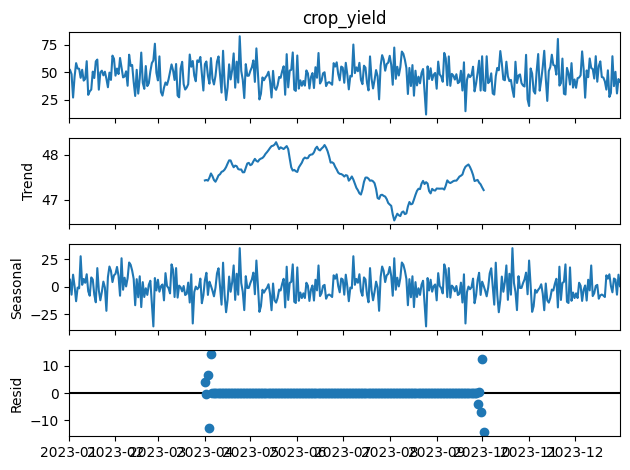

In [ ]:
# Create a new DataFrame with 'date' as the index
df_time_series = df_processed.set_index('date')

# Perform STL decomposition
result = seasonal_decompose(df_time_series['crop_yield'], model='additive', period=180)

# Plot the decomposed components
result.plot()
plt.show()

This decomposition can be helpful for understanding the data, selecting appropriate features for modeling, and potentially improving the accuracy of crop yield predictions.

1.   The STL decomposition confirms that while there might be some subtle seasonality in the crop yield data, it is not the primary driver of the observed fluctuations.
2.   The presence of significant residuals suggests that other factors, such as weather events, soil conditions, and pest infestations, could be playing a more dominant role in influencing crop yield variability.



# Time Series Forecasting (Prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplee34wdv/53sjk09v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplee34wdv/hxidarkd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25610', 'data', 'file=/tmp/tmplee34wdv/53sjk09v.json', 'init=/tmp/tmplee34wdv/hxidarkd.json', 'output', 'file=/tmp/tmplee34wdv/prophet_modelovikumna/prophet_model-20250117072923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:29:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:29:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


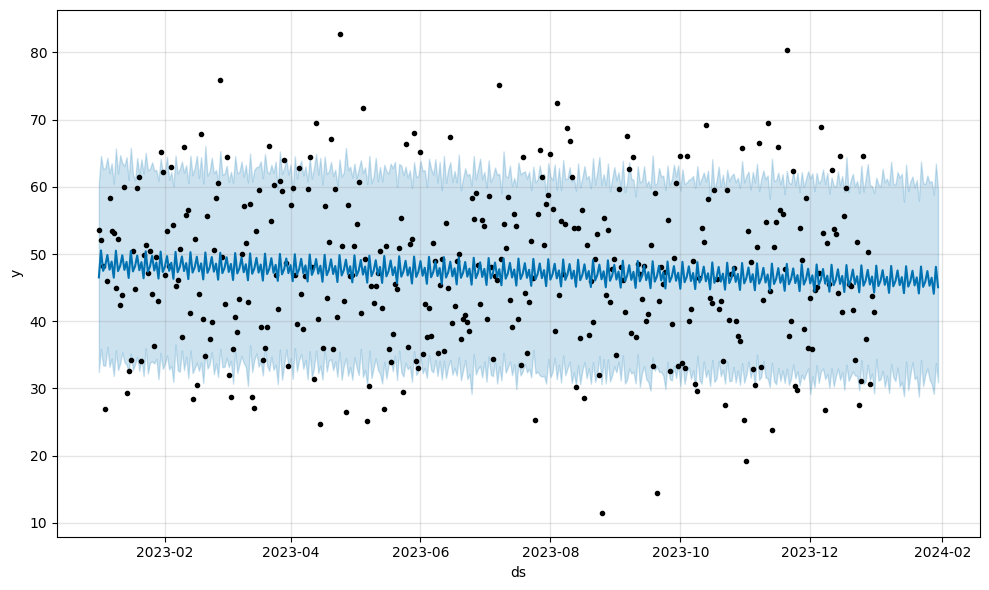

In [ ]:
# Prepare data for Prophet
prophet_df = df_processed[['date', 'crop_yield']].rename(columns={'date':'ds', 'crop_yield':'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(prophet_df)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=30) # Predict for the next 30 days

# Make predictions
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

A blue line representing the predicted trend for the next 30 days.

1.   A blue line representing the predicted trend for the next 30 days.
2.   A shaded area around the blue line, indicating the uncertainty interval for the predictions. The wider the shaded area, the less confident the model is about the predicted value.
3.   The Prophet model(Predicted Crop Yield Trend) appears to capture the overall trend and variability in the crop yield data reasonably well. The predicted values follow the general pattern of the actual data.
4.   The uncertainty intervals are relatively wide, indicating that there is considerable uncertainty associated with the predictions. This is expected in time series forecasting, especially when dealing with noisy data and complex patterns.



In [ ]:
# Evaluate Prophet model
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract actual values for the forecast period
# Use the length of the prediction period (30 days) instead of len(forecast)
y_true = df_processed['crop_yield'][-30:]

# Extract predicted values for the forecast period
y_pred = forecast['yhat'][-30:]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Prophet Model - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Prophet Model - MAE: 8.44, RMSE: 10.75


Mean Absolute Error (MAE): 8.44

*   This indicates that, on average, the Prophet model's predictions deviate from the actual crop yields by 8.44 units. The lower the MAE, the better the model's accuracy.

Root Mean Squared Error (RMSE): 10.75

*   RMSE provides a measure of the average magnitude of the prediction errors. A lower RMSE indicates better model accuracy.






# **Hyperparameter Tuning**

In [ ]:
from prophet import Prophet
from sklearn.model_selection import ParameterGrid

# Define parameter grid for Prophet
param_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1],
    'holidays': [None]  # You can add holidays relevant to your region if available
}

best_params = {}
best_mae = float('inf')

for params in ParameterGrid(param_grid):
    model = Prophet(**params)
    model.fit(prophet_df)
    forecast = model.predict(future)
    y_pred = forecast['yhat'][-30:]
    mae = mean_absolute_error(y_true, y_pred)

    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best Parameters: {best_params}")

# Train the model with best parameters
best_model = Prophet(**best_params)
best_model.fit(prophet_df)
best_forecast = best_model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplee34wdv/p6_s38ku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplee34wdv/xgouwyu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58601', 'data', 'file=/tmp/tmplee34wdv/p6_s38ku.json', 'init=/tmp/tmplee34wdv/xgouwyu6.json', 'output', 'file=/tmp/tmplee34wdv/prophet_modelo56fkz4i/prophet_model-20250117072924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:29:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:29:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Best Parameters: {'changepoint_prior_scale': 0.01, 'holidays': None, 'seasonality_mode': 'multiplicative'}


The hyperparameter tuning process explored different combinations of parameters and identified the best-performing configuration.


1.   The changepoint_prior_scale controls the flexibility of the model in adapting to changes in the trend. A lower value typically results in a smoother trend, while a higher value allows for more flexibility.

2.   The seasonality_mode determines whether the seasonality component is additive or multiplicative.



# **Overall, this project has provided a foundation for building a crop yield prediction model. By iteratively refining the model and incorporating new data and insights, it is possible to develop a more accurate and robust system that can assist farmers in making informed decisions and improving agricultural productivity.**